In [3]:
import opendatasets as od
# od.download("https://www.kaggle.com/datasets/haqishen/rsna-cropped-2d-224-0920-2m")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: atikarahmanpaddo
Your Kaggle Key: ········


100%|██████████| 37.5G/37.5G [08:20<00:00, 80.5MB/s]


In [1]:
DEBUG = False

In [2]:
#!pip install opencv-python
#!pip install timm
#!pip install pandas
#!pip install albumentations
#!pip install matplotlib
#!pip install datasets
#!pip install opendatasets

In [3]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
#device = torch.device('cuda')
device=torch.cuda.set_device(2)
torch.backends.cudnn.benchmark = True

## Config

In [4]:
kernel_type = '0920_2d_lstmv22headv2_convnn_224_15_6ch_8flip_augv2_drl3_rov1p2_rov3p2_bs4_lr6e5_eta6e6_lw151_50ep'
load_kernel = None
load_last = True

n_folds = 5
backbone = 'convnext_nano'

image_size = 224
n_slice_per_c = 15
in_chans = 6

init_lr = 23e-5
eta_min = 23e-6
lw = [15, 1]
batch_size = 8
drop_rate = 0.
drop_rate_last = 0.3
drop_path_rate = 0.
p_mixup = 0.5
p_rand_order = 0.2
p_rand_order_v1 = 0.2

data_dir = 'rsna-cropped-2d-224-0920-2m/cropped_2d_224_15_ext0_5ch_0920_2m/cropped_2d_224_15_ext0_5ch_0920_2m'
use_amp = True
num_workers = 4
out_dim = 1

n_epochs = 50

log_dir = './logs'
model_dir = './models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [5]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, border_mode=4, p=0.7),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=3),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.5),

    albumentations.Cutout(max_h_size=int(image_size * 0.5), max_w_size=int(image_size * 0.5), num_holes=1, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/home/apaddo/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/apaddo/.local/lib/python3.9/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/home/apaddo/.local/lib/python3.9/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


## DataFrame

In [6]:
df = pd.read_csv('rsna-cropped-2d-224-0920-2m/train_seg.csv')
df = df.sample(16).reset_index(drop=True) if DEBUG else df

df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_file,image_folder,w,h,d,t,fold
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,NaN,/data/rsna-2022-cervical-spine-fracture-detect...,512,512,243,1.000,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,NaN,/data/rsna-2022-cervical-spine-fracture-detect...,512,512,406,0.500,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,NaN,/data/rsna-2022-cervical-spine-fracture-detect...,512,512,385,0.625,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,NaN,/data/rsna-2022-cervical-spine-fracture-detect...,512,512,501,0.600,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,/data/rsna-2022-cervical-spine-fracture-detect...,/data/rsna-2022-cervical-spine-fracture-detect...,512,512,199,1.000,0


## Dataset

In [7]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        images = []
        
        tmp = list(range(7))
        ### random order v3
        if self.mode == 'train' and random.random() < p_rand_order:
            random.shuffle(tmp)
        ###
        for cid in (tmp):
            for ind in list(range(n_slice_per_c)):
                filepath = os.path.join(data_dir, f'{row.StudyInstanceUID}_{cid+1}_{ind}.npy')
                image = np.load(filepath)
                image = self.transform(image=image)['image']
                image = image.transpose(2, 0, 1).astype(np.float32) / 255.
                images.append(image)
        images = np.stack(images, 0)

        if self.mode != 'test':
            labels = []
            for i in row[[f'C{x+1}' for x in tmp]].tolist():
                labels += [i] * n_slice_per_c
            images = torch.tensor(images).float()
            labels = torch.tensor(labels).float()
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]
                labels = labels[indices]

            return images, labels
        else:
            return torch.tensor(images).float()

In [8]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLSDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)

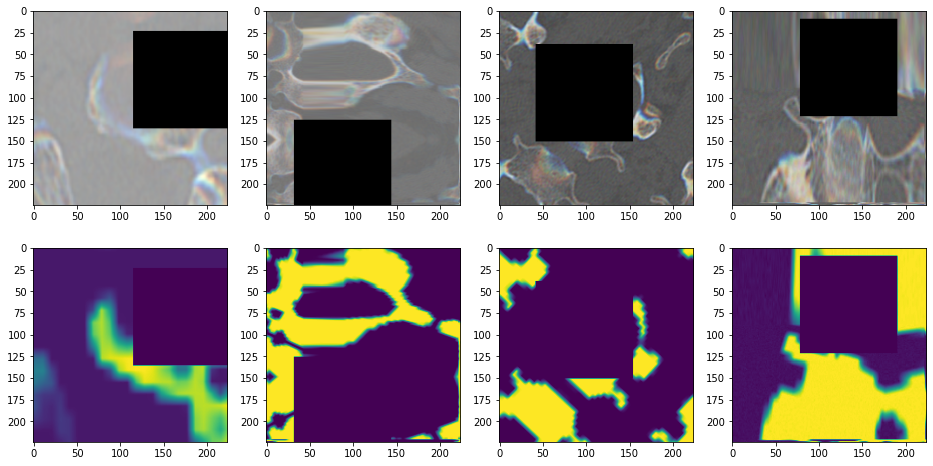

In [9]:
rcParams['figure.figsize'] = 16,8
f, axarr = plt.subplots(2,4)
for p in range(4):
    idx = p * 20
    imgs, lbl = dataset_show[idx]
    axarr[0, p].imshow(imgs[35][:3].permute(1, 2, 0))
    axarr[1, p].imshow(imgs[35][-1])

## Model

In [10]:
class TimmModelType2(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModelType2, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, out_dim),
        )
        self.lstm2 = nn.LSTM(hdim, 256, num_layers=2, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 1),
        )



    def forward(self, x):  # (bs, nc*7, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * n_slice_per_c * 7, in_chans, image_size, image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice_per_c * 7, -1)
        feat1, _ = self.lstm(feat)
        feat1 = feat1.contiguous().view(bs * n_slice_per_c * 7, 512)
        feat2, _ = self.lstm2(feat)

        return self.head(feat1), self.head2(feat2[:, 0])

In [11]:
m = TimmModelType2(backbone)
#m(torch.rand(2, n_slice_per_c, in_chans, image_size, image_size)).shape

## Loss & Metric

In [12]:
bce = nn.BCEWithLogitsLoss(reduction='none')


def criterion(logits, targets, activated=False):
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = bce(logits.view(-1), targets.view(-1))
    losses[targets.view(-1) > 0] *= 2.
    logits = logits.to(torch.device('cuda'))
    norm = torch.ones(logits.view(-1).shape[0]).to('cuda')
    
#     if torch.cuda.is_available():
#         norm.cuda()
    
    norm[targets.view(-1) > 0] *= 2
    return losses.sum() / norm.sum()

## Train & Valid func

In [13]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    train_loss1 = []
    train_loss2 = []
    bar = tqdm(loader_train)
    for images, targets in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
        
        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, targets, targets_mix, lam = mixup(images, targets)

        with amp.autocast():
            logits, logits2 = model(images)
            loss1 = criterion(logits, targets)
            loss2 = criterion(logits2, targets.max(1).values)
            loss = (loss1 * lw[0] + loss2 * lw[1]) / sum(lw)
            if do_mixup:
                loss11 = criterion(logits, targets_mix)
                loss22 = criterion(logits2, targets_mix.max(1).values)
                loss = loss * lam  + (loss11 * lw[0] + loss22 * lw[1]) / sum(lw) * (1 - lam)
        train_loss1.append(loss1.item())
        train_loss2.append(loss2.item())
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss1[-30:]):.4f} {np.mean(train_loss2[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    valid_loss1 = []
    valid_loss2 = []
    outputs = []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets in bar:
            images = images.cuda()
            targets = targets.cuda()

            logits, logits2 = model(images)
            loss1 = criterion(logits, targets)
            loss2 = criterion(logits2, targets.max(1).values)
            loss = (loss1 + loss2) / 2.
            valid_loss1.append(loss1.item())
            valid_loss2.append(loss2.item())
            valid_loss.append(loss.item())
            bar.set_description(f'smth:{np.mean(valid_loss1[-30:]):.4f} {np.mean(valid_loss2[-30:]):.4f}')

    return np.mean(valid_loss)



/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use cas

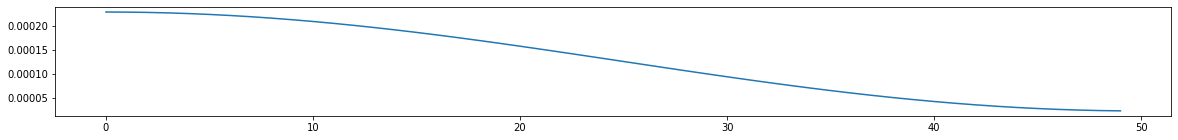

In [14]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

## Training

In [15]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmModelType2(backbone, pretrained=True)
    model = model.to(device)
    
    if torch.cuda.is_available():
        model.cuda()

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    from_epoch = 0
    metric_best = np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    model = torch.quantization.convert(model.eval(), inplace=False)
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 23e-5)
    model.qconfig = torch.ao.quantization.get_default_qat_qconfig('fbgemm')
    
    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)
        if epoch < from_epoch + 1:
            print(logs[epoch-1])
            continue

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss = valid_func(model, loader_valid)
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [16]:
run(0)

1614 404
Fri Jan 13 09:47:44 2023 Epoch: 1


  0%|          | 0/51 [00:00<?, ?it/s]/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
smth:0.5025 0.6891: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


Fri Jan 13 09:52:43 2023 Fold 0, Epoch 1, lr: 0.0002300, train loss: 0.60214, valid loss: 0.58992, metric: 0.589918.
metric_best (inf --> 0.589918). Saving model ...
Fri Jan 13 09:52:43 2023 Epoch: 2


smth:0.4919 0.6853: 100%|██████████| 51/51 [00:38<00:00,  1.32it/s]


Fri Jan 13 09:57:33 2023 Fold 0, Epoch 2, lr: 0.0002300, train loss: 0.55216, valid loss: 0.58129, metric: 0.581293.
metric_best (0.589918 --> 0.581293). Saving model ...
Fri Jan 13 09:57:34 2023 Epoch: 3


smth:0.4796 0.6956: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 10:02:19 2023 Fold 0, Epoch 3, lr: 0.0002300, train loss: 0.52589, valid loss: 0.57658, metric: 0.576578.
metric_best (0.581293 --> 0.576578). Saving model ...
Fri Jan 13 10:02:19 2023 Epoch: 4


smth:0.4729 0.6763: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 10:07:08 2023 Fold 0, Epoch 4, lr: 0.0002300, train loss: 0.50973, valid loss: 0.56724, metric: 0.567244.
metric_best (0.576578 --> 0.567244). Saving model ...
Fri Jan 13 10:07:09 2023 Epoch: 5


smth:0.4887 0.6851: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


Fri Jan 13 10:11:56 2023 Fold 0, Epoch 5, lr: 0.0002300, train loss: 0.49980, valid loss: 0.57766, metric: 0.577658.
Fri Jan 13 10:11:56 2023 Epoch: 6


smth:0.4760 0.6826: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Fri Jan 13 10:16:45 2023 Fold 0, Epoch 6, lr: 0.0002300, train loss: 0.49578, valid loss: 0.56945, metric: 0.569450.
Fri Jan 13 10:16:45 2023 Epoch: 7


smth:0.4779 0.6907: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s]


Fri Jan 13 10:21:30 2023 Fold 0, Epoch 7, lr: 0.0002300, train loss: 0.49065, valid loss: 0.57207, metric: 0.572066.
Fri Jan 13 10:21:30 2023 Epoch: 8


smth:0.4787 0.6885: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 10:26:18 2023 Fold 0, Epoch 8, lr: 0.0002300, train loss: 0.48727, valid loss: 0.57281, metric: 0.572814.
Fri Jan 13 10:26:18 2023 Epoch: 9


smth:0.4814 0.6763: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 10:31:02 2023 Fold 0, Epoch 9, lr: 0.0002300, train loss: 0.48470, valid loss: 0.56930, metric: 0.569303.
Fri Jan 13 10:31:02 2023 Epoch: 10


smth:0.4777 0.6773: 100%|██████████| 51/51 [00:37<00:00,  1.35it/s]


Fri Jan 13 10:35:55 2023 Fold 0, Epoch 10, lr: 0.0002300, train loss: 0.48688, valid loss: 0.56488, metric: 0.564883.
metric_best (0.567244 --> 0.564883). Saving model ...
Fri Jan 13 10:35:55 2023 Epoch: 11


smth:0.4765 0.6712: 100%|██████████| 51/51 [00:36<00:00,  1.40it/s]


Fri Jan 13 10:40:45 2023 Fold 0, Epoch 11, lr: 0.0002300, train loss: 0.48220, valid loss: 0.56420, metric: 0.564198.
metric_best (0.564883 --> 0.564198). Saving model ...
Fri Jan 13 10:40:45 2023 Epoch: 12


smth:0.4781 0.6681: 100%|██████████| 51/51 [00:37<00:00,  1.35it/s]


Fri Jan 13 10:45:41 2023 Fold 0, Epoch 12, lr: 0.0002300, train loss: 0.48338, valid loss: 0.56310, metric: 0.563100.
metric_best (0.564198 --> 0.563100). Saving model ...
Fri Jan 13 10:45:41 2023 Epoch: 13


smth:0.4875 0.6878: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 10:50:32 2023 Fold 0, Epoch 13, lr: 0.0002300, train loss: 0.48144, valid loss: 0.57337, metric: 0.573372.
Fri Jan 13 10:50:33 2023 Epoch: 14


smth:0.4768 0.6756: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


Fri Jan 13 10:55:27 2023 Fold 0, Epoch 14, lr: 0.0002300, train loss: 0.48273, valid loss: 0.56675, metric: 0.566749.
Fri Jan 13 10:55:27 2023 Epoch: 15


smth:0.4866 0.6923: 100%|██████████| 51/51 [00:39<00:00,  1.29it/s]


Fri Jan 13 11:00:27 2023 Fold 0, Epoch 15, lr: 0.0002300, train loss: 0.48124, valid loss: 0.57538, metric: 0.575383.
Fri Jan 13 11:00:27 2023 Epoch: 16


smth:0.4812 0.6801: 100%|██████████| 51/51 [00:41<00:00,  1.24it/s]


Fri Jan 13 11:05:26 2023 Fold 0, Epoch 16, lr: 0.0002300, train loss: 0.48070, valid loss: 0.56709, metric: 0.567088.
Fri Jan 13 11:05:26 2023 Epoch: 17


smth:0.4807 0.6665: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


Fri Jan 13 11:10:21 2023 Fold 0, Epoch 17, lr: 0.0002300, train loss: 0.48012, valid loss: 0.55989, metric: 0.559886.
metric_best (0.563100 --> 0.559886). Saving model ...
Fri Jan 13 11:10:21 2023 Epoch: 18


smth:0.5005 0.6873: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 11:15:13 2023 Fold 0, Epoch 18, lr: 0.0002300, train loss: 0.47949, valid loss: 0.58370, metric: 0.583705.
Fri Jan 13 11:15:13 2023 Epoch: 19


smth:0.4672 0.6545: 100%|██████████| 51/51 [00:38<00:00,  1.32it/s]


Fri Jan 13 11:20:08 2023 Fold 0, Epoch 19, lr: 0.0002300, train loss: 0.47970, valid loss: 0.54972, metric: 0.549722.
metric_best (0.559886 --> 0.549722). Saving model ...
Fri Jan 13 11:20:08 2023 Epoch: 20


smth:0.4779 0.6799: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 11:25:00 2023 Fold 0, Epoch 20, lr: 0.0002300, train loss: 0.48115, valid loss: 0.56355, metric: 0.563547.
Fri Jan 13 11:25:00 2023 Epoch: 21


smth:0.4868 0.6667: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 11:30:01 2023 Fold 0, Epoch 21, lr: 0.0002300, train loss: 0.47936, valid loss: 0.56475, metric: 0.564748.
Fri Jan 13 11:30:01 2023 Epoch: 22


smth:0.4790 0.6627: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 11:34:54 2023 Fold 0, Epoch 22, lr: 0.0002300, train loss: 0.47782, valid loss: 0.55960, metric: 0.559596.
Fri Jan 13 11:34:54 2023 Epoch: 23


smth:0.4764 0.6715: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 11:39:54 2023 Fold 0, Epoch 23, lr: 0.0002300, train loss: 0.48029, valid loss: 0.56176, metric: 0.561762.
Fri Jan 13 11:39:54 2023 Epoch: 24


smth:0.4743 0.6607: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


Fri Jan 13 11:44:54 2023 Fold 0, Epoch 24, lr: 0.0002300, train loss: 0.47768, valid loss: 0.55383, metric: 0.553829.
Fri Jan 13 11:44:54 2023 Epoch: 25


smth:0.4714 0.6644: 100%|██████████| 51/51 [00:36<00:00,  1.40it/s]


Fri Jan 13 11:49:55 2023 Fold 0, Epoch 25, lr: 0.0002300, train loss: 0.47693, valid loss: 0.55322, metric: 0.553222.
Fri Jan 13 11:49:55 2023 Epoch: 26


smth:0.4756 0.6591: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


Fri Jan 13 11:54:56 2023 Fold 0, Epoch 26, lr: 0.0002300, train loss: 0.47438, valid loss: 0.55470, metric: 0.554704.
Fri Jan 13 11:54:56 2023 Epoch: 27


smth:0.4802 0.6647: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s]


Fri Jan 13 11:59:53 2023 Fold 0, Epoch 27, lr: 0.0002300, train loss: 0.47819, valid loss: 0.55631, metric: 0.556313.
Fri Jan 13 11:59:54 2023 Epoch: 28


smth:0.4764 0.6660: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 12:04:51 2023 Fold 0, Epoch 28, lr: 0.0002300, train loss: 0.47702, valid loss: 0.55667, metric: 0.556669.
Fri Jan 13 12:04:51 2023 Epoch: 29


smth:0.4947 0.6588: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s]


Fri Jan 13 12:09:54 2023 Fold 0, Epoch 29, lr: 0.0002300, train loss: 0.47682, valid loss: 0.56356, metric: 0.563563.
Fri Jan 13 12:09:54 2023 Epoch: 30


smth:0.4741 0.6680: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 12:14:56 2023 Fold 0, Epoch 30, lr: 0.0002300, train loss: 0.47542, valid loss: 0.55825, metric: 0.558247.
Fri Jan 13 12:14:56 2023 Epoch: 31


smth:0.4761 0.6609: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 12:19:51 2023 Fold 0, Epoch 31, lr: 0.0002300, train loss: 0.47536, valid loss: 0.55345, metric: 0.553452.
Fri Jan 13 12:19:51 2023 Epoch: 32


smth:0.4709 0.6765: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


Fri Jan 13 12:24:52 2023 Fold 0, Epoch 32, lr: 0.0002300, train loss: 0.47560, valid loss: 0.56218, metric: 0.562182.
Fri Jan 13 12:24:53 2023 Epoch: 33


smth:0.4683 0.6625: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 12:29:53 2023 Fold 0, Epoch 33, lr: 0.0002300, train loss: 0.47845, valid loss: 0.55212, metric: 0.552119.
Fri Jan 13 12:29:53 2023 Epoch: 34


smth:0.4752 0.6712: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 12:34:46 2023 Fold 0, Epoch 34, lr: 0.0002300, train loss: 0.47622, valid loss: 0.55745, metric: 0.557452.
Fri Jan 13 12:34:46 2023 Epoch: 35


smth:0.4679 0.6495: 100%|██████████| 51/51 [00:36<00:00,  1.38it/s]


Fri Jan 13 12:39:41 2023 Fold 0, Epoch 35, lr: 0.0002300, train loss: 0.47493, valid loss: 0.54518, metric: 0.545176.
metric_best (0.549722 --> 0.545176). Saving model ...
Fri Jan 13 12:39:41 2023 Epoch: 36


smth:0.4754 0.6620: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s]


Fri Jan 13 12:44:35 2023 Fold 0, Epoch 36, lr: 0.0002300, train loss: 0.47704, valid loss: 0.55419, metric: 0.554186.
Fri Jan 13 12:44:35 2023 Epoch: 37


smth:0.4717 0.6706: 100%|██████████| 51/51 [00:39<00:00,  1.29it/s]


Fri Jan 13 12:49:30 2023 Fold 0, Epoch 37, lr: 0.0002300, train loss: 0.47412, valid loss: 0.55662, metric: 0.556622.
Fri Jan 13 12:49:30 2023 Epoch: 38


smth:0.4779 0.6533: 100%|██████████| 51/51 [00:40<00:00,  1.27it/s]


Fri Jan 13 12:54:24 2023 Fold 0, Epoch 38, lr: 0.0002300, train loss: 0.47370, valid loss: 0.55260, metric: 0.552600.
Fri Jan 13 12:54:24 2023 Epoch: 39


smth:0.4778 0.6687: 100%|██████████| 51/51 [00:40<00:00,  1.27it/s]


Fri Jan 13 12:59:22 2023 Fold 0, Epoch 39, lr: 0.0002300, train loss: 0.47723, valid loss: 0.55794, metric: 0.557938.
Fri Jan 13 12:59:22 2023 Epoch: 40


smth:0.4713 0.6737: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s]


Fri Jan 13 13:04:18 2023 Fold 0, Epoch 40, lr: 0.0002300, train loss: 0.47135, valid loss: 0.55552, metric: 0.555515.
Fri Jan 13 13:04:18 2023 Epoch: 41


smth:0.4705 0.6580: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s]


Fri Jan 13 13:09:11 2023 Fold 0, Epoch 41, lr: 0.0002300, train loss: 0.47621, valid loss: 0.54782, metric: 0.547821.
Fri Jan 13 13:09:11 2023 Epoch: 42


smth:0.4675 0.6644: 100%|██████████| 51/51 [00:36<00:00,  1.42it/s]


Fri Jan 13 13:14:02 2023 Fold 0, Epoch 42, lr: 0.0002300, train loss: 0.47266, valid loss: 0.54854, metric: 0.548539.
Fri Jan 13 13:14:02 2023 Epoch: 43


smth:0.4768 0.6605: 100%|██████████| 51/51 [00:37<00:00,  1.38it/s]


Fri Jan 13 13:18:53 2023 Fold 0, Epoch 43, lr: 0.0002300, train loss: 0.47303, valid loss: 0.55389, metric: 0.553889.
Fri Jan 13 13:18:54 2023 Epoch: 44


smth:0.4865 0.6846: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 13:23:43 2023 Fold 0, Epoch 44, lr: 0.0002300, train loss: 0.47033, valid loss: 0.56734, metric: 0.567336.
Fri Jan 13 13:23:44 2023 Epoch: 45


smth:0.4788 0.6780: 100%|██████████| 51/51 [00:36<00:00,  1.40it/s]


Fri Jan 13 13:28:36 2023 Fold 0, Epoch 45, lr: 0.0002300, train loss: 0.47357, valid loss: 0.56079, metric: 0.560790.
Fri Jan 13 13:28:36 2023 Epoch: 46


smth:0.4722 0.6516: 100%|██████████| 51/51 [00:39<00:00,  1.28it/s]


Fri Jan 13 13:33:29 2023 Fold 0, Epoch 46, lr: 0.0002300, train loss: 0.47255, valid loss: 0.54934, metric: 0.549341.
Fri Jan 13 13:33:29 2023 Epoch: 47


smth:0.4681 0.6691: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s]


Fri Jan 13 13:38:20 2023 Fold 0, Epoch 47, lr: 0.0002300, train loss: 0.47030, valid loss: 0.55276, metric: 0.552758.
Fri Jan 13 13:38:20 2023 Epoch: 48


smth:0.4685 0.6670: 100%|██████████| 51/51 [00:36<00:00,  1.40it/s]


Fri Jan 13 13:43:10 2023 Fold 0, Epoch 48, lr: 0.0002300, train loss: 0.47110, valid loss: 0.55317, metric: 0.553167.
Fri Jan 13 13:43:10 2023 Epoch: 49


smth:0.4726 0.6636: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s]


Fri Jan 13 13:48:00 2023 Fold 0, Epoch 49, lr: 0.0002300, train loss: 0.47322, valid loss: 0.55501, metric: 0.555010.
Fri Jan 13 13:48:00 2023 Epoch: 50


smth:0.4657 0.6558: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s]


Fri Jan 13 13:52:53 2023 Fold 0, Epoch 50, lr: 0.0002300, train loss: 0.47159, valid loss: 0.54466, metric: 0.544656.
metric_best (0.545176 --> 0.544656). Saving model ...


In [17]:
run(1)

1614 404
Fri Jan 13 13:52:54 2023 Epoch: 1


  0%|          | 0/51 [00:00<?, ?it/s]/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
smth:0.5786 0.7223: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


Fri Jan 13 13:57:30 2023 Fold 1, Epoch 1, lr: 0.0002300, train loss: 0.66892, valid loss: 0.63991, metric: 0.639910.
metric_best (inf --> 0.639910). Saving model ...
Fri Jan 13 13:57:30 2023 Epoch: 2


smth:0.4938 0.7043: 100%|██████████| 51/51 [00:36<00:00,  1.38it/s]


Fri Jan 13 14:02:04 2023 Fold 1, Epoch 2, lr: 0.0002300, train loss: 0.58899, valid loss: 0.58978, metric: 0.589782.
metric_best (0.639910 --> 0.589782). Saving model ...
Fri Jan 13 14:02:05 2023 Epoch: 3


smth:0.4967 0.7105: 100%|██████████| 51/51 [00:37<00:00,  1.38it/s]


Fri Jan 13 14:06:39 2023 Fold 1, Epoch 3, lr: 0.0002300, train loss: 0.54550, valid loss: 0.59724, metric: 0.597241.
Fri Jan 13 14:06:40 2023 Epoch: 4


smth:0.4663 0.7405: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


Fri Jan 13 14:11:14 2023 Fold 1, Epoch 4, lr: 0.0002300, train loss: 0.52269, valid loss: 0.59239, metric: 0.592392.
Fri Jan 13 14:11:14 2023 Epoch: 5


smth:0.4632 0.7370: 100%|██████████| 51/51 [00:34<00:00,  1.46it/s]


Fri Jan 13 14:15:45 2023 Fold 1, Epoch 5, lr: 0.0002300, train loss: 0.50885, valid loss: 0.58870, metric: 0.588704.
metric_best (0.589782 --> 0.588704). Saving model ...
Fri Jan 13 14:15:46 2023 Epoch: 6


smth:0.5020 0.7472: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s]


Fri Jan 13 14:20:18 2023 Fold 1, Epoch 6, lr: 0.0002300, train loss: 0.50200, valid loss: 0.60599, metric: 0.605993.
Fri Jan 13 14:20:18 2023 Epoch: 7


smth:0.4662 0.6721: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 14:24:54 2023 Fold 1, Epoch 7, lr: 0.0002300, train loss: 0.49419, valid loss: 0.56546, metric: 0.565460.
metric_best (0.588704 --> 0.565460). Saving model ...
Fri Jan 13 14:24:54 2023 Epoch: 8


smth:0.4741 0.7150: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 14:29:30 2023 Fold 1, Epoch 8, lr: 0.0002300, train loss: 0.49229, valid loss: 0.58131, metric: 0.581308.
Fri Jan 13 14:29:30 2023 Epoch: 9


smth:0.5044 0.7328: 100%|██████████| 51/51 [00:34<00:00,  1.46it/s]


Fri Jan 13 14:34:00 2023 Fold 1, Epoch 9, lr: 0.0002300, train loss: 0.49092, valid loss: 0.60394, metric: 0.603936.
Fri Jan 13 14:34:00 2023 Epoch: 10


smth:0.4605 0.7150: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 14:38:53 2023 Fold 1, Epoch 10, lr: 0.0002300, train loss: 0.48908, valid loss: 0.57962, metric: 0.579616.
Fri Jan 13 14:38:53 2023 Epoch: 11


smth:0.4664 0.7119: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s]


Fri Jan 13 14:43:26 2023 Fold 1, Epoch 11, lr: 0.0002300, train loss: 0.48722, valid loss: 0.57848, metric: 0.578477.
Fri Jan 13 14:43:26 2023 Epoch: 12


smth:0.4776 0.6989: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s]


Fri Jan 13 14:48:37 2023 Fold 1, Epoch 12, lr: 0.0002300, train loss: 0.48565, valid loss: 0.57745, metric: 0.577451.
Fri Jan 13 14:48:37 2023 Epoch: 13


smth:0.5177 0.7158: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 14:53:39 2023 Fold 1, Epoch 13, lr: 0.0002300, train loss: 0.48437, valid loss: 0.60154, metric: 0.601536.
Fri Jan 13 14:53:39 2023 Epoch: 14


smth:0.4728 0.6973: 100%|██████████| 51/51 [00:54<00:00,  1.07s/it]


Fri Jan 13 14:59:16 2023 Fold 1, Epoch 14, lr: 0.0002300, train loss: 0.48230, valid loss: 0.57182, metric: 0.571816.
Fri Jan 13 14:59:16 2023 Epoch: 15


smth:0.4574 0.6491: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


Fri Jan 13 15:06:25 2023 Fold 1, Epoch 15, lr: 0.0002300, train loss: 0.47943, valid loss: 0.55290, metric: 0.552900.
metric_best (0.565460 --> 0.552900). Saving model ...
Fri Jan 13 15:06:25 2023 Epoch: 16


smth:0.4803 0.6817: 100%|██████████| 51/51 [00:36<00:00,  1.38it/s]


Fri Jan 13 15:12:08 2023 Fold 1, Epoch 16, lr: 0.0002300, train loss: 0.47979, valid loss: 0.57121, metric: 0.571207.
Fri Jan 13 15:12:08 2023 Epoch: 17


smth:0.5323 0.6833: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


Fri Jan 13 15:17:10 2023 Fold 1, Epoch 17, lr: 0.0002300, train loss: 0.47841, valid loss: 0.59447, metric: 0.594469.
Fri Jan 13 15:17:10 2023 Epoch: 18


smth:0.4694 0.6640: 100%|██████████| 51/51 [00:40<00:00,  1.27it/s]


Fri Jan 13 15:22:58 2023 Fold 1, Epoch 18, lr: 0.0002300, train loss: 0.47716, valid loss: 0.56275, metric: 0.562750.
Fri Jan 13 15:22:58 2023 Epoch: 19


smth:0.4672 0.6460: 100%|██████████| 51/51 [00:36<00:00,  1.40it/s]


Fri Jan 13 15:27:59 2023 Fold 1, Epoch 19, lr: 0.0002300, train loss: 0.48236, valid loss: 0.55195, metric: 0.551950.
metric_best (0.552900 --> 0.551950). Saving model ...
Fri Jan 13 15:27:59 2023 Epoch: 20


smth:0.4891 0.6893: 100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Fri Jan 13 15:33:21 2023 Fold 1, Epoch 20, lr: 0.0002300, train loss: 0.47967, valid loss: 0.57721, metric: 0.577215.
Fri Jan 13 15:33:22 2023 Epoch: 21


smth:0.5116 0.7282: 100%|██████████| 51/51 [00:37<00:00,  1.35it/s]


Fri Jan 13 15:38:07 2023 Fold 1, Epoch 21, lr: 0.0002300, train loss: 0.47814, valid loss: 0.60319, metric: 0.603190.
Fri Jan 13 15:38:07 2023 Epoch: 22


smth:0.4726 0.6823: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 15:43:08 2023 Fold 1, Epoch 22, lr: 0.0002300, train loss: 0.47661, valid loss: 0.56794, metric: 0.567939.
Fri Jan 13 15:43:08 2023 Epoch: 23


smth:0.4841 0.6882: 100%|██████████| 51/51 [00:36<00:00,  1.38it/s]


Fri Jan 13 15:48:52 2023 Fold 1, Epoch 23, lr: 0.0002300, train loss: 0.47515, valid loss: 0.57461, metric: 0.574614.
Fri Jan 13 15:48:52 2023 Epoch: 24


smth:0.4612 0.6385: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 15:54:00 2023 Fold 1, Epoch 24, lr: 0.0002300, train loss: 0.47364, valid loss: 0.54708, metric: 0.547084.
metric_best (0.551950 --> 0.547084). Saving model ...
Fri Jan 13 15:54:00 2023 Epoch: 25


smth:0.4907 0.6683: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 15:58:43 2023 Fold 1, Epoch 25, lr: 0.0002300, train loss: 0.47668, valid loss: 0.57123, metric: 0.571230.
Fri Jan 13 15:58:43 2023 Epoch: 26


smth:0.4838 0.6432: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 16:03:16 2023 Fold 1, Epoch 26, lr: 0.0002300, train loss: 0.47669, valid loss: 0.55972, metric: 0.559718.
Fri Jan 13 16:03:16 2023 Epoch: 27


smth:0.4714 0.6564: 100%|██████████| 51/51 [00:40<00:00,  1.25it/s]


Fri Jan 13 16:08:06 2023 Fold 1, Epoch 27, lr: 0.0002300, train loss: 0.47559, valid loss: 0.55810, metric: 0.558100.
Fri Jan 13 16:08:06 2023 Epoch: 28


smth:0.4886 0.6570: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s]


Fri Jan 13 16:12:40 2023 Fold 1, Epoch 28, lr: 0.0002300, train loss: 0.47662, valid loss: 0.56509, metric: 0.565093.
Fri Jan 13 16:12:40 2023 Epoch: 29


smth:0.4873 0.6596: 100%|██████████| 51/51 [00:33<00:00,  1.51it/s]


Fri Jan 13 16:17:14 2023 Fold 1, Epoch 29, lr: 0.0002300, train loss: 0.47352, valid loss: 0.56455, metric: 0.564549.
Fri Jan 13 16:17:14 2023 Epoch: 30


smth:0.4849 0.6427: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Fri Jan 13 16:21:50 2023 Fold 1, Epoch 30, lr: 0.0002300, train loss: 0.47265, valid loss: 0.55734, metric: 0.557335.
Fri Jan 13 16:21:50 2023 Epoch: 31


smth:0.4744 0.6582: 100%|██████████| 51/51 [00:38<00:00,  1.32it/s]


Fri Jan 13 16:26:28 2023 Fold 1, Epoch 31, lr: 0.0002300, train loss: 0.47423, valid loss: 0.55888, metric: 0.558876.
Fri Jan 13 16:26:28 2023 Epoch: 32


smth:0.4700 0.6374: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 16:31:00 2023 Fold 1, Epoch 32, lr: 0.0002300, train loss: 0.47155, valid loss: 0.55055, metric: 0.550552.
Fri Jan 13 16:31:00 2023 Epoch: 33


smth:0.5120 0.6481: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


Fri Jan 13 16:35:39 2023 Fold 1, Epoch 33, lr: 0.0002300, train loss: 0.47096, valid loss: 0.57184, metric: 0.571836.
Fri Jan 13 16:35:39 2023 Epoch: 34


smth:0.4779 0.6432: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s]


Fri Jan 13 16:41:04 2023 Fold 1, Epoch 34, lr: 0.0002300, train loss: 0.47273, valid loss: 0.55386, metric: 0.553856.
Fri Jan 13 16:41:04 2023 Epoch: 35


smth:0.4809 0.6175: 100%|██████████| 51/51 [00:37<00:00,  1.38it/s]


Fri Jan 13 16:46:49 2023 Fold 1, Epoch 35, lr: 0.0002300, train loss: 0.47083, valid loss: 0.54894, metric: 0.548942.
Fri Jan 13 16:46:50 2023 Epoch: 36


smth:0.4604 0.6439: 100%|██████████| 51/51 [00:34<00:00,  1.49it/s]


Fri Jan 13 16:52:01 2023 Fold 1, Epoch 36, lr: 0.0002300, train loss: 0.46996, valid loss: 0.54902, metric: 0.549020.
Fri Jan 13 16:52:01 2023 Epoch: 37


smth:0.4509 0.6154: 100%|██████████| 51/51 [00:39<00:00,  1.30it/s]


Fri Jan 13 16:56:39 2023 Fold 1, Epoch 37, lr: 0.0002300, train loss: 0.46922, valid loss: 0.53461, metric: 0.534613.
metric_best (0.547084 --> 0.534613). Saving model ...
Fri Jan 13 16:56:39 2023 Epoch: 38


smth:0.4907 0.6451: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 17:01:11 2023 Fold 1, Epoch 38, lr: 0.0002300, train loss: 0.47011, valid loss: 0.56093, metric: 0.560927.
Fri Jan 13 17:01:11 2023 Epoch: 39


smth:0.4681 0.6276: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s]


Fri Jan 13 17:05:46 2023 Fold 1, Epoch 39, lr: 0.0002300, train loss: 0.47436, valid loss: 0.54565, metric: 0.545653.
Fri Jan 13 17:05:46 2023 Epoch: 40


smth:0.4529 0.6282: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 17:10:21 2023 Fold 1, Epoch 40, lr: 0.0002300, train loss: 0.47157, valid loss: 0.53990, metric: 0.539900.
Fri Jan 13 17:10:21 2023 Epoch: 41


smth:0.4738 0.6397: 100%|██████████| 51/51 [00:40<00:00,  1.27it/s]


Fri Jan 13 17:14:58 2023 Fold 1, Epoch 41, lr: 0.0002300, train loss: 0.46752, valid loss: 0.54983, metric: 0.549833.
Fri Jan 13 17:14:58 2023 Epoch: 42


smth:0.4556 0.6201: 100%|██████████| 51/51 [00:39<00:00,  1.28it/s]


Fri Jan 13 17:19:40 2023 Fold 1, Epoch 42, lr: 0.0002300, train loss: 0.46651, valid loss: 0.53873, metric: 0.538728.
Fri Jan 13 17:19:40 2023 Epoch: 43


smth:0.4423 0.6330: 100%|██████████| 51/51 [00:39<00:00,  1.28it/s]


Fri Jan 13 17:24:18 2023 Fold 1, Epoch 43, lr: 0.0002300, train loss: 0.46684, valid loss: 0.53751, metric: 0.537510.
Fri Jan 13 17:24:18 2023 Epoch: 44


smth:0.4542 0.6377: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s]


Fri Jan 13 17:28:56 2023 Fold 1, Epoch 44, lr: 0.0002300, train loss: 0.46962, valid loss: 0.54175, metric: 0.541750.
Fri Jan 13 17:28:56 2023 Epoch: 45


smth:0.4580 0.6391: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


Fri Jan 13 17:33:29 2023 Fold 1, Epoch 45, lr: 0.0002300, train loss: 0.46820, valid loss: 0.54418, metric: 0.544183.
Fri Jan 13 17:33:30 2023 Epoch: 46


smth:0.4751 0.6479: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 17:38:04 2023 Fold 1, Epoch 46, lr: 0.0002300, train loss: 0.46718, valid loss: 0.55539, metric: 0.555389.
Fri Jan 13 17:38:04 2023 Epoch: 47


smth:0.4336 0.5999: 100%|██████████| 51/51 [00:34<00:00,  1.50it/s]


Fri Jan 13 17:42:36 2023 Fold 1, Epoch 47, lr: 0.0002300, train loss: 0.46563, valid loss: 0.52493, metric: 0.524935.
metric_best (0.534613 --> 0.524935). Saving model ...
Fri Jan 13 17:42:36 2023 Epoch: 48


smth:0.4524 0.6144: 100%|██████████| 51/51 [00:39<00:00,  1.29it/s]


Fri Jan 13 17:47:16 2023 Fold 1, Epoch 48, lr: 0.0002300, train loss: 0.46631, valid loss: 0.53458, metric: 0.534577.
Fri Jan 13 17:47:16 2023 Epoch: 49


smth:0.4758 0.6592: 100%|██████████| 51/51 [00:34<00:00,  1.46it/s]


Fri Jan 13 17:51:47 2023 Fold 1, Epoch 49, lr: 0.0002300, train loss: 0.46825, valid loss: 0.55861, metric: 0.558611.
Fri Jan 13 17:51:47 2023 Epoch: 50


smth:0.4370 0.6132: 100%|██████████| 51/51 [00:33<00:00,  1.50it/s]


Fri Jan 13 17:56:18 2023 Fold 1, Epoch 50, lr: 0.0002300, train loss: 0.46511, valid loss: 0.52769, metric: 0.527694.


In [18]:
run(2)

1615 403
Fri Jan 13 17:56:19 2023 Epoch: 1


  0%|          | 0/51 [00:00<?, ?it/s]/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
smth:0.5398 0.7497: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Fri Jan 13 18:00:58 2023 Fold 2, Epoch 1, lr: 0.0002300, train loss: 0.63294, valid loss: 0.64574, metric: 0.645742.
metric_best (inf --> 0.645742). Saving model ...
Fri Jan 13 18:00:58 2023 Epoch: 2


smth:0.5005 0.7785: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s]


Fri Jan 13 18:05:41 2023 Fold 2, Epoch 2, lr: 0.0002300, train loss: 0.56847, valid loss: 0.62103, metric: 0.621026.
metric_best (0.645742 --> 0.621026). Saving model ...
Fri Jan 13 18:05:42 2023 Epoch: 3


smth:0.4890 0.7204: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 18:10:19 2023 Fold 2, Epoch 3, lr: 0.0002300, train loss: 0.53444, valid loss: 0.59581, metric: 0.595810.
metric_best (0.621026 --> 0.595810). Saving model ...
Fri Jan 13 18:10:19 2023 Epoch: 4


smth:0.4814 0.6302: 100%|██████████| 51/51 [00:34<00:00,  1.46it/s]


Fri Jan 13 18:14:58 2023 Fold 2, Epoch 4, lr: 0.0002300, train loss: 0.51383, valid loss: 0.56705, metric: 0.567049.
metric_best (0.595810 --> 0.567049). Saving model ...
Fri Jan 13 18:14:58 2023 Epoch: 5


smth:0.4790 0.6839: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


Fri Jan 13 18:19:37 2023 Fold 2, Epoch 5, lr: 0.0002300, train loss: 0.50623, valid loss: 0.57548, metric: 0.575478.
Fri Jan 13 18:19:37 2023 Epoch: 6


smth:0.4751 0.7081: 100%|██████████| 51/51 [00:34<00:00,  1.46it/s]


Fri Jan 13 18:24:17 2023 Fold 2, Epoch 6, lr: 0.0002300, train loss: 0.49727, valid loss: 0.58203, metric: 0.582029.
Fri Jan 13 18:24:17 2023 Epoch: 7


smth:0.4832 0.7247: 100%|██████████| 51/51 [00:38<00:00,  1.32it/s]


Fri Jan 13 18:28:59 2023 Fold 2, Epoch 7, lr: 0.0002300, train loss: 0.49331, valid loss: 0.58722, metric: 0.587217.
Fri Jan 13 18:28:59 2023 Epoch: 8


smth:0.4775 0.7010: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 18:33:39 2023 Fold 2, Epoch 8, lr: 0.0002300, train loss: 0.48982, valid loss: 0.57633, metric: 0.576327.
Fri Jan 13 18:33:40 2023 Epoch: 9


smth:0.4995 0.7819: 100%|██████████| 51/51 [00:35<00:00,  1.46it/s]


Fri Jan 13 18:38:18 2023 Fold 2, Epoch 9, lr: 0.0002300, train loss: 0.48659, valid loss: 0.61380, metric: 0.613805.
Fri Jan 13 18:38:18 2023 Epoch: 10


smth:0.4929 0.7303: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s]


Fri Jan 13 18:42:58 2023 Fold 2, Epoch 10, lr: 0.0002300, train loss: 0.48436, valid loss: 0.59486, metric: 0.594857.
Fri Jan 13 18:42:58 2023 Epoch: 11


smth:0.4882 0.6933: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


Fri Jan 13 18:47:38 2023 Fold 2, Epoch 11, lr: 0.0002300, train loss: 0.48542, valid loss: 0.57859, metric: 0.578593.
Fri Jan 13 18:47:38 2023 Epoch: 12


smth:0.4744 0.7246: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 18:52:22 2023 Fold 2, Epoch 12, lr: 0.0002300, train loss: 0.48587, valid loss: 0.58588, metric: 0.585877.
Fri Jan 13 18:52:22 2023 Epoch: 13


smth:0.4948 0.7454: 100%|██████████| 51/51 [00:36<00:00,  1.40it/s]


Fri Jan 13 18:57:01 2023 Fold 2, Epoch 13, lr: 0.0002300, train loss: 0.48190, valid loss: 0.59939, metric: 0.599392.
Fri Jan 13 18:57:01 2023 Epoch: 14


smth:0.4763 0.6772: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s]


Fri Jan 13 19:01:43 2023 Fold 2, Epoch 14, lr: 0.0002300, train loss: 0.48165, valid loss: 0.57133, metric: 0.571332.
Fri Jan 13 19:01:43 2023 Epoch: 15


smth:0.4892 0.7060: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


Fri Jan 13 19:06:28 2023 Fold 2, Epoch 15, lr: 0.0002300, train loss: 0.48069, valid loss: 0.58597, metric: 0.585971.
Fri Jan 13 19:06:28 2023 Epoch: 16


smth:0.4879 0.7042: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s]


Fri Jan 13 19:11:11 2023 Fold 2, Epoch 16, lr: 0.0002300, train loss: 0.48148, valid loss: 0.58112, metric: 0.581117.
Fri Jan 13 19:11:12 2023 Epoch: 17


smth:0.4871 0.6734: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s]


Fri Jan 13 19:15:56 2023 Fold 2, Epoch 17, lr: 0.0002300, train loss: 0.48002, valid loss: 0.57216, metric: 0.572159.
Fri Jan 13 19:15:56 2023 Epoch: 18


smth:0.4904 0.7116: 100%|██████████| 51/51 [00:38<00:00,  1.34it/s]


Fri Jan 13 19:20:42 2023 Fold 2, Epoch 18, lr: 0.0002300, train loss: 0.47793, valid loss: 0.58324, metric: 0.583241.
Fri Jan 13 19:20:42 2023 Epoch: 19


smth:0.4895 0.6825: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Fri Jan 13 19:25:21 2023 Fold 2, Epoch 19, lr: 0.0002300, train loss: 0.47955, valid loss: 0.57526, metric: 0.575265.
Fri Jan 13 19:25:21 2023 Epoch: 20


smth:0.5015 0.7100: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 19:30:04 2023 Fold 2, Epoch 20, lr: 0.0002300, train loss: 0.47665, valid loss: 0.59170, metric: 0.591697.
Fri Jan 13 19:30:04 2023 Epoch: 21


smth:0.4884 0.6831: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Fri Jan 13 19:34:44 2023 Fold 2, Epoch 21, lr: 0.0002300, train loss: 0.47422, valid loss: 0.57502, metric: 0.575021.
Fri Jan 13 19:34:44 2023 Epoch: 22


smth:0.4879 0.6722: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Fri Jan 13 19:39:26 2023 Fold 2, Epoch 22, lr: 0.0002300, train loss: 0.47864, valid loss: 0.57262, metric: 0.572623.
Fri Jan 13 19:39:26 2023 Epoch: 23


smth:0.4827 0.6762: 100%|██████████| 51/51 [00:36<00:00,  1.40it/s]


Fri Jan 13 19:44:06 2023 Fold 2, Epoch 23, lr: 0.0002300, train loss: 0.47737, valid loss: 0.57472, metric: 0.574723.
Fri Jan 13 19:44:06 2023 Epoch: 24


smth:0.4728 0.6551: 100%|██████████| 51/51 [00:40<00:00,  1.26it/s]


Fri Jan 13 19:48:52 2023 Fold 2, Epoch 24, lr: 0.0002300, train loss: 0.47505, valid loss: 0.56379, metric: 0.563786.
metric_best (0.567049 --> 0.563786). Saving model ...
Fri Jan 13 19:48:52 2023 Epoch: 25


smth:0.5370 0.7769: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Fri Jan 13 19:53:32 2023 Fold 2, Epoch 25, lr: 0.0002300, train loss: 0.49731, valid loss: 0.63531, metric: 0.635306.
Fri Jan 13 19:53:32 2023 Epoch: 26


smth:0.5166 0.7475: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s]


Fri Jan 13 19:58:12 2023 Fold 2, Epoch 26, lr: 0.0002300, train loss: 0.49813, valid loss: 0.61847, metric: 0.618469.
Fri Jan 13 19:58:13 2023 Epoch: 27


smth:0.5237 0.6960: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Fri Jan 13 20:02:51 2023 Fold 2, Epoch 27, lr: 0.0002300, train loss: 0.50046, valid loss: 0.59968, metric: 0.599676.
Fri Jan 13 20:02:51 2023 Epoch: 28


smth:0.5432 0.6637: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 20:07:30 2023 Fold 2, Epoch 28, lr: 0.0002300, train loss: 0.49859, valid loss: 0.59784, metric: 0.597838.
Fri Jan 13 20:07:30 2023 Epoch: 29


smth:0.5336 0.6681: 100%|██████████| 51/51 [00:34<00:00,  1.49it/s]


Fri Jan 13 20:12:08 2023 Fold 2, Epoch 29, lr: 0.0002300, train loss: 0.49789, valid loss: 0.59947, metric: 0.599474.
Fri Jan 13 20:12:08 2023 Epoch: 30


smth:0.4818 0.6407: 100%|██████████| 51/51 [00:34<00:00,  1.49it/s]


Fri Jan 13 20:16:47 2023 Fold 2, Epoch 30, lr: 0.0002300, train loss: 0.48754, valid loss: 0.56305, metric: 0.563050.
metric_best (0.563786 --> 0.563050). Saving model ...
Fri Jan 13 20:16:47 2023 Epoch: 31


smth:0.4743 0.6253: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


Fri Jan 13 20:21:26 2023 Fold 2, Epoch 31, lr: 0.0002300, train loss: 0.47428, valid loss: 0.55880, metric: 0.558803.
metric_best (0.563050 --> 0.558803). Saving model ...
Fri Jan 13 20:21:26 2023 Epoch: 32


smth:0.4678 0.6232: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s]


Fri Jan 13 20:26:07 2023 Fold 2, Epoch 32, lr: 0.0002300, train loss: 0.47756, valid loss: 0.55169, metric: 0.551694.
metric_best (0.558803 --> 0.551694). Saving model ...
Fri Jan 13 20:26:07 2023 Epoch: 33


smth:0.4636 0.6284: 100%|██████████| 51/51 [00:40<00:00,  1.27it/s]


Fri Jan 13 20:30:51 2023 Fold 2, Epoch 33, lr: 0.0002300, train loss: 0.47542, valid loss: 0.55254, metric: 0.552537.
Fri Jan 13 20:30:51 2023 Epoch: 34


smth:0.4661 0.6229: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 20:35:30 2023 Fold 2, Epoch 34, lr: 0.0002300, train loss: 0.47602, valid loss: 0.55425, metric: 0.554248.
Fri Jan 13 20:35:30 2023 Epoch: 35


smth:0.4669 0.6152: 100%|██████████| 51/51 [00:34<00:00,  1.46it/s]


Fri Jan 13 20:40:08 2023 Fold 2, Epoch 35, lr: 0.0002300, train loss: 0.47675, valid loss: 0.55371, metric: 0.553707.
Fri Jan 13 20:40:08 2023 Epoch: 36


smth:0.4657 0.6247: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Fri Jan 13 20:44:47 2023 Fold 2, Epoch 36, lr: 0.0002300, train loss: 0.47371, valid loss: 0.54940, metric: 0.549403.
metric_best (0.551694 --> 0.549403). Saving model ...
Fri Jan 13 20:44:47 2023 Epoch: 37


smth:0.4633 0.6195: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 20:49:26 2023 Fold 2, Epoch 37, lr: 0.0002300, train loss: 0.47382, valid loss: 0.55194, metric: 0.551942.
Fri Jan 13 20:49:26 2023 Epoch: 38


smth:0.4621 0.6270: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 20:54:06 2023 Fold 2, Epoch 38, lr: 0.0002300, train loss: 0.47204, valid loss: 0.54771, metric: 0.547706.
metric_best (0.549403 --> 0.547706). Saving model ...
Fri Jan 13 20:54:06 2023 Epoch: 39


smth:0.4644 0.6098: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 20:58:45 2023 Fold 2, Epoch 39, lr: 0.0002300, train loss: 0.47199, valid loss: 0.55261, metric: 0.552605.
Fri Jan 13 20:58:45 2023 Epoch: 40


smth:0.4805 0.6177: 100%|██████████| 51/51 [00:39<00:00,  1.30it/s]


Fri Jan 13 21:03:28 2023 Fold 2, Epoch 40, lr: 0.0002300, train loss: 0.47012, valid loss: 0.55419, metric: 0.554194.
Fri Jan 13 21:03:28 2023 Epoch: 41


smth:0.4703 0.6262: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


Fri Jan 13 21:08:11 2023 Fold 2, Epoch 41, lr: 0.0002300, train loss: 0.47232, valid loss: 0.55393, metric: 0.553933.
Fri Jan 13 21:08:11 2023 Epoch: 42


smth:0.4640 0.6326: 100%|██████████| 51/51 [00:38<00:00,  1.34it/s]


Fri Jan 13 21:12:54 2023 Fold 2, Epoch 42, lr: 0.0002300, train loss: 0.47087, valid loss: 0.55235, metric: 0.552355.
Fri Jan 13 21:12:54 2023 Epoch: 43


smth:0.4628 0.6152: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 21:17:32 2023 Fold 2, Epoch 43, lr: 0.0002300, train loss: 0.47083, valid loss: 0.54924, metric: 0.549236.
Fri Jan 13 21:17:32 2023 Epoch: 44


smth:0.4683 0.6222: 100%|██████████| 51/51 [00:34<00:00,  1.49it/s]


Fri Jan 13 21:22:10 2023 Fold 2, Epoch 44, lr: 0.0002300, train loss: 0.47190, valid loss: 0.55292, metric: 0.552921.
Fri Jan 13 21:22:10 2023 Epoch: 45


smth:0.4615 0.6103: 100%|██████████| 51/51 [00:38<00:00,  1.31it/s]


Fri Jan 13 21:26:52 2023 Fold 2, Epoch 45, lr: 0.0002300, train loss: 0.47061, valid loss: 0.55020, metric: 0.550203.
Fri Jan 13 21:26:52 2023 Epoch: 46


smth:0.4724 0.6359: 100%|██████████| 51/51 [00:36<00:00,  1.42it/s]


Fri Jan 13 21:31:32 2023 Fold 2, Epoch 46, lr: 0.0002300, train loss: 0.46906, valid loss: 0.55581, metric: 0.555809.
Fri Jan 13 21:31:32 2023 Epoch: 47


smth:0.4613 0.6115: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 21:36:11 2023 Fold 2, Epoch 47, lr: 0.0002300, train loss: 0.46741, valid loss: 0.54879, metric: 0.548786.
Fri Jan 13 21:36:12 2023 Epoch: 48


smth:0.4748 0.5915: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s]


Fri Jan 13 21:40:54 2023 Fold 2, Epoch 48, lr: 0.0002300, train loss: 0.47021, valid loss: 0.55242, metric: 0.552421.
Fri Jan 13 21:40:54 2023 Epoch: 49


smth:0.4666 0.6325: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 21:45:33 2023 Fold 2, Epoch 49, lr: 0.0002300, train loss: 0.46958, valid loss: 0.55585, metric: 0.555852.
Fri Jan 13 21:45:33 2023 Epoch: 50


smth:0.4693 0.6098: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s]


Fri Jan 13 21:50:15 2023 Fold 2, Epoch 50, lr: 0.0002300, train loss: 0.47011, valid loss: 0.55363, metric: 0.553630.


In [19]:
run(3)

1614 404
Fri Jan 13 21:50:16 2023 Epoch: 1


  0%|          | 0/51 [00:00<?, ?it/s]/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
smth:0.5328 0.6887: 100%|██████████| 51/51 [00:42<00:00,  1.21it/s]


Fri Jan 13 21:54:55 2023 Fold 3, Epoch 1, lr: 0.0002300, train loss: 0.67273, valid loss: 0.61028, metric: 0.610281.
metric_best (inf --> 0.610281). Saving model ...
Fri Jan 13 21:54:56 2023 Epoch: 2


smth:0.4916 0.7060: 100%|██████████| 51/51 [00:35<00:00,  1.46it/s]


Fri Jan 13 21:59:26 2023 Fold 3, Epoch 2, lr: 0.0002300, train loss: 0.58798, valid loss: 0.59526, metric: 0.595258.
metric_best (0.610281 --> 0.595258). Saving model ...
Fri Jan 13 21:59:26 2023 Epoch: 3


smth:0.4724 0.6842: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 22:03:58 2023 Fold 3, Epoch 3, lr: 0.0002300, train loss: 0.54623, valid loss: 0.57685, metric: 0.576848.
metric_best (0.595258 --> 0.576848). Saving model ...
Fri Jan 13 22:03:58 2023 Epoch: 4


smth:0.4603 0.7137: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s]


Fri Jan 13 22:08:33 2023 Fold 3, Epoch 4, lr: 0.0002300, train loss: 0.52061, valid loss: 0.58280, metric: 0.582802.
Fri Jan 13 22:08:33 2023 Epoch: 5


smth:0.4611 0.7047: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s]


Fri Jan 13 22:13:08 2023 Fold 3, Epoch 5, lr: 0.0002300, train loss: 0.50669, valid loss: 0.57912, metric: 0.579120.
Fri Jan 13 22:13:08 2023 Epoch: 6


smth:0.4589 0.6771: 100%|██████████| 51/51 [00:39<00:00,  1.30it/s]


Fri Jan 13 22:17:47 2023 Fold 3, Epoch 6, lr: 0.0002300, train loss: 0.49930, valid loss: 0.56796, metric: 0.567961.
metric_best (0.576848 --> 0.567961). Saving model ...
Fri Jan 13 22:17:47 2023 Epoch: 7


smth:0.4592 0.7042: 100%|██████████| 51/51 [00:34<00:00,  1.46it/s]


Fri Jan 13 22:22:19 2023 Fold 3, Epoch 7, lr: 0.0002300, train loss: 0.49417, valid loss: 0.57777, metric: 0.577765.
Fri Jan 13 22:22:19 2023 Epoch: 8


smth:0.4562 0.6976: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


Fri Jan 13 22:26:51 2023 Fold 3, Epoch 8, lr: 0.0002300, train loss: 0.48912, valid loss: 0.57291, metric: 0.572909.
Fri Jan 13 22:26:51 2023 Epoch: 9


smth:0.4585 0.7019: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 22:31:28 2023 Fold 3, Epoch 9, lr: 0.0002300, train loss: 0.48663, valid loss: 0.57667, metric: 0.576666.
Fri Jan 13 22:31:28 2023 Epoch: 10


smth:0.4695 0.6917: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


Fri Jan 13 22:35:59 2023 Fold 3, Epoch 10, lr: 0.0002300, train loss: 0.48448, valid loss: 0.57661, metric: 0.576610.
Fri Jan 13 22:35:59 2023 Epoch: 11


smth:0.4593 0.6875: 100%|██████████| 51/51 [00:34<00:00,  1.49it/s]


Fri Jan 13 22:40:31 2023 Fold 3, Epoch 11, lr: 0.0002300, train loss: 0.48526, valid loss: 0.57138, metric: 0.571381.
Fri Jan 13 22:40:32 2023 Epoch: 12


smth:0.4539 0.6889: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s]


Fri Jan 13 22:45:08 2023 Fold 3, Epoch 12, lr: 0.0002300, train loss: 0.48343, valid loss: 0.56879, metric: 0.568794.
Fri Jan 13 22:45:08 2023 Epoch: 13


smth:0.4573 0.6774: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 22:49:43 2023 Fold 3, Epoch 13, lr: 0.0002300, train loss: 0.48118, valid loss: 0.56675, metric: 0.566750.
metric_best (0.567961 --> 0.566750). Saving model ...
Fri Jan 13 22:49:43 2023 Epoch: 14


smth:0.4584 0.6906: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 22:54:17 2023 Fold 3, Epoch 14, lr: 0.0002300, train loss: 0.48168, valid loss: 0.57009, metric: 0.570088.
Fri Jan 13 22:54:17 2023 Epoch: 15


smth:0.5042 0.6753: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s]


Fri Jan 13 22:58:54 2023 Fold 3, Epoch 15, lr: 0.0002300, train loss: 0.48213, valid loss: 0.58833, metric: 0.588333.
Fri Jan 13 22:58:54 2023 Epoch: 16


smth:0.4557 0.6761: 100%|██████████| 51/51 [00:40<00:00,  1.26it/s]


Fri Jan 13 23:03:31 2023 Fold 3, Epoch 16, lr: 0.0002300, train loss: 0.48026, valid loss: 0.56385, metric: 0.563845.
metric_best (0.566750 --> 0.563845). Saving model ...
Fri Jan 13 23:03:31 2023 Epoch: 17


smth:0.4559 0.6700: 100%|██████████| 51/51 [00:40<00:00,  1.26it/s]


Fri Jan 13 23:08:07 2023 Fold 3, Epoch 17, lr: 0.0002300, train loss: 0.47791, valid loss: 0.56100, metric: 0.560996.
metric_best (0.563845 --> 0.560996). Saving model ...
Fri Jan 13 23:08:08 2023 Epoch: 18


smth:0.4564 0.6808: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]


Fri Jan 13 23:12:38 2023 Fold 3, Epoch 18, lr: 0.0002300, train loss: 0.47950, valid loss: 0.56593, metric: 0.565928.
Fri Jan 13 23:12:38 2023 Epoch: 19


smth:0.4548 0.6757: 100%|██████████| 51/51 [00:40<00:00,  1.26it/s]


Fri Jan 13 23:17:14 2023 Fold 3, Epoch 19, lr: 0.0002300, train loss: 0.48072, valid loss: 0.56262, metric: 0.562616.
Fri Jan 13 23:17:14 2023 Epoch: 20


smth:0.4570 0.6723: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 23:21:47 2023 Fold 3, Epoch 20, lr: 0.0002300, train loss: 0.47784, valid loss: 0.56301, metric: 0.563010.
Fri Jan 13 23:21:47 2023 Epoch: 21


smth:0.4575 0.6810: 100%|██████████| 51/51 [00:38<00:00,  1.32it/s]


Fri Jan 13 23:26:23 2023 Fold 3, Epoch 21, lr: 0.0002300, train loss: 0.47838, valid loss: 0.56635, metric: 0.566350.
Fri Jan 13 23:26:23 2023 Epoch: 22


smth:0.4640 0.6802: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 23:30:56 2023 Fold 3, Epoch 22, lr: 0.0002300, train loss: 0.47840, valid loss: 0.56860, metric: 0.568605.
Fri Jan 13 23:30:57 2023 Epoch: 23


smth:0.4589 0.6767: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Fri Jan 13 23:35:28 2023 Fold 3, Epoch 23, lr: 0.0002300, train loss: 0.47716, valid loss: 0.56461, metric: 0.564614.
Fri Jan 13 23:35:28 2023 Epoch: 24


smth:0.4597 0.6779: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s]


Fri Jan 13 23:40:05 2023 Fold 3, Epoch 24, lr: 0.0002300, train loss: 0.47691, valid loss: 0.56505, metric: 0.565047.
Fri Jan 13 23:40:05 2023 Epoch: 25


smth:0.4769 0.6715: 100%|██████████| 51/51 [00:37<00:00,  1.35it/s]


Fri Jan 13 23:44:45 2023 Fold 3, Epoch 25, lr: 0.0002300, train loss: 0.47744, valid loss: 0.57145, metric: 0.571452.
Fri Jan 13 23:44:45 2023 Epoch: 26


smth:0.4661 0.6706: 100%|██████████| 51/51 [00:35<00:00,  1.45it/s]


Fri Jan 13 23:49:24 2023 Fold 3, Epoch 26, lr: 0.0002300, train loss: 0.47613, valid loss: 0.56751, metric: 0.567513.
Fri Jan 13 23:49:24 2023 Epoch: 27


smth:0.4574 0.6690: 100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


Fri Jan 13 23:53:59 2023 Fold 3, Epoch 27, lr: 0.0002300, train loss: 0.47817, valid loss: 0.56246, metric: 0.562461.
Fri Jan 13 23:53:59 2023 Epoch: 28


smth:0.4580 0.6678: 100%|██████████| 51/51 [01:02<00:00,  1.23s/it]


Fri Jan 13 23:59:54 2023 Fold 3, Epoch 28, lr: 0.0002300, train loss: 0.47452, valid loss: 0.56225, metric: 0.562253.
Fri Jan 13 23:59:54 2023 Epoch: 29


smth:0.4540 0.6709: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s]


Sat Jan 14 00:06:55 2023 Fold 3, Epoch 29, lr: 0.0002300, train loss: 0.47587, valid loss: 0.55948, metric: 0.559485.
metric_best (0.560996 --> 0.559485). Saving model ...
Sat Jan 14 00:06:56 2023 Epoch: 30


smth:0.4544 0.6618: 100%|██████████| 51/51 [00:38<00:00,  1.32it/s]


Sat Jan 14 00:11:40 2023 Fold 3, Epoch 30, lr: 0.0002300, train loss: 0.47513, valid loss: 0.55791, metric: 0.557912.
metric_best (0.559485 --> 0.557912). Saving model ...
Sat Jan 14 00:11:40 2023 Epoch: 31


smth:0.4668 0.6657: 100%|██████████| 51/51 [00:36<00:00,  1.40it/s]


Sat Jan 14 00:16:21 2023 Fold 3, Epoch 31, lr: 0.0002300, train loss: 0.47435, valid loss: 0.56491, metric: 0.564915.
Sat Jan 14 00:16:21 2023 Epoch: 32


smth:0.4524 0.6635: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Sat Jan 14 00:21:02 2023 Fold 3, Epoch 32, lr: 0.0002300, train loss: 0.47684, valid loss: 0.55689, metric: 0.556889.
metric_best (0.557912 --> 0.556889). Saving model ...
Sat Jan 14 00:21:02 2023 Epoch: 33


smth:0.4768 0.6654: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s]


Sat Jan 14 00:25:48 2023 Fold 3, Epoch 33, lr: 0.0002300, train loss: 0.47614, valid loss: 0.57219, metric: 0.572187.
Sat Jan 14 00:25:48 2023 Epoch: 34


smth:0.4730 0.6713: 100%|██████████| 51/51 [00:36<00:00,  1.40it/s]


Sat Jan 14 00:30:36 2023 Fold 3, Epoch 34, lr: 0.0002300, train loss: 0.47525, valid loss: 0.56948, metric: 0.569483.
Sat Jan 14 00:30:36 2023 Epoch: 35


smth:0.4512 0.6646: 100%|██████████| 51/51 [00:39<00:00,  1.29it/s]


Sat Jan 14 00:35:25 2023 Fold 3, Epoch 35, lr: 0.0002300, train loss: 0.47395, valid loss: 0.55668, metric: 0.556681.
metric_best (0.556889 --> 0.556681). Saving model ...
Sat Jan 14 00:35:25 2023 Epoch: 36


smth:0.4550 0.6546: 100%|██████████| 51/51 [00:38<00:00,  1.31it/s]


Sat Jan 14 00:40:12 2023 Fold 3, Epoch 36, lr: 0.0002300, train loss: 0.47451, valid loss: 0.55575, metric: 0.555747.
metric_best (0.556681 --> 0.555747). Saving model ...
Sat Jan 14 00:40:13 2023 Epoch: 37


smth:0.4661 0.6667: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]


Sat Jan 14 00:44:51 2023 Fold 3, Epoch 37, lr: 0.0002300, train loss: 0.47496, valid loss: 0.56450, metric: 0.564499.
Sat Jan 14 00:44:51 2023 Epoch: 38


smth:0.4530 0.6604: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


Sat Jan 14 00:51:34 2023 Fold 3, Epoch 38, lr: 0.0002300, train loss: 0.47577, valid loss: 0.55656, metric: 0.556562.
Sat Jan 14 00:51:34 2023 Epoch: 39


smth:0.4538 0.6561: 100%|██████████| 51/51 [00:58<00:00,  1.14s/it]


Sat Jan 14 00:59:15 2023 Fold 3, Epoch 39, lr: 0.0002300, train loss: 0.47492, valid loss: 0.55706, metric: 0.557059.
Sat Jan 14 00:59:15 2023 Epoch: 40


smth:0.4602 0.6675: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


Sat Jan 14 01:06:51 2023 Fold 3, Epoch 40, lr: 0.0002300, train loss: 0.47313, valid loss: 0.56235, metric: 0.562346.
Sat Jan 14 01:06:51 2023 Epoch: 41


smth:0.4586 0.6615: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


Sat Jan 14 01:14:31 2023 Fold 3, Epoch 41, lr: 0.0002300, train loss: 0.47503, valid loss: 0.56020, metric: 0.560204.
Sat Jan 14 01:14:31 2023 Epoch: 42


smth:0.4637 0.6688: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


Sat Jan 14 01:22:06 2023 Fold 3, Epoch 42, lr: 0.0002300, train loss: 0.47329, valid loss: 0.56386, metric: 0.563860.
Sat Jan 14 01:22:06 2023 Epoch: 43


smth:0.4596 0.6588: 100%|██████████| 51/51 [01:01<00:00,  1.21s/it]


Sat Jan 14 01:29:52 2023 Fold 3, Epoch 43, lr: 0.0002300, train loss: 0.47319, valid loss: 0.55755, metric: 0.557551.
Sat Jan 14 01:29:52 2023 Epoch: 44


smth:0.4921 0.6627: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


Sat Jan 14 01:37:25 2023 Fold 3, Epoch 44, lr: 0.0002300, train loss: 0.47238, valid loss: 0.57458, metric: 0.574583.
Sat Jan 14 01:37:25 2023 Epoch: 45


smth:0.4669 0.6569: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


Sat Jan 14 01:44:56 2023 Fold 3, Epoch 45, lr: 0.0002300, train loss: 0.47228, valid loss: 0.56044, metric: 0.560437.
Sat Jan 14 01:44:56 2023 Epoch: 46


smth:0.4679 0.6644: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


Sat Jan 14 01:52:29 2023 Fold 3, Epoch 46, lr: 0.0002300, train loss: 0.47311, valid loss: 0.56223, metric: 0.562228.
Sat Jan 14 01:52:29 2023 Epoch: 47


smth:0.4643 0.6599: 100%|██████████| 51/51 [00:58<00:00,  1.14s/it]


Sat Jan 14 01:59:59 2023 Fold 3, Epoch 47, lr: 0.0002300, train loss: 0.47335, valid loss: 0.56084, metric: 0.560836.
Sat Jan 14 01:59:59 2023 Epoch: 48


smth:0.4682 0.6652: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


Sat Jan 14 02:07:37 2023 Fold 3, Epoch 48, lr: 0.0002300, train loss: 0.47477, valid loss: 0.56528, metric: 0.565279.
Sat Jan 14 02:07:37 2023 Epoch: 49


smth:0.4648 0.6606: 100%|██████████| 51/51 [00:58<00:00,  1.14s/it]


Sat Jan 14 02:15:14 2023 Fold 3, Epoch 49, lr: 0.0002300, train loss: 0.47524, valid loss: 0.56275, metric: 0.562749.
Sat Jan 14 02:15:14 2023 Epoch: 50


smth:0.4643 0.6648: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


Sat Jan 14 02:22:44 2023 Fold 3, Epoch 50, lr: 0.0002300, train loss: 0.47315, valid loss: 0.56435, metric: 0.564353.


In [ ]:
run(4)

1615 403
Sat Jan 14 02:22:45 2023 Epoch: 1


  0%|          | 0/51 [00:00<?, ?it/s]/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
smth:0.5153 0.8028: 100%|██████████| 51/51 [00:59<00:00,  1.16s/it]


Sat Jan 14 02:30:15 2023 Fold 4, Epoch 1, lr: 0.0002300, train loss: 0.60954, valid loss: 0.65814, metric: 0.658144.
metric_best (inf --> 0.658144). Saving model ...
Sat Jan 14 02:30:15 2023 Epoch: 2


smth:0.4938 0.7793: 100%|██████████| 51/51 [00:59<00:00,  1.17s/it]


Sat Jan 14 02:37:51 2023 Fold 4, Epoch 2, lr: 0.0002300, train loss: 0.55758, valid loss: 0.63483, metric: 0.634827.
metric_best (0.658144 --> 0.634827). Saving model ...
Sat Jan 14 02:37:51 2023 Epoch: 3


smth:0.4609 0.7276: 100%|██████████| 51/51 [00:59<00:00,  1.16s/it]


Sat Jan 14 02:45:22 2023 Fold 4, Epoch 3, lr: 0.0002300, train loss: 0.53079, valid loss: 0.59656, metric: 0.596561.
metric_best (0.634827 --> 0.596561). Saving model ...
Sat Jan 14 02:45:22 2023 Epoch: 4


smth:0.4666 0.7382: 100%|██████████| 51/51 [00:58<00:00,  1.16s/it]


Sat Jan 14 02:52:54 2023 Fold 4, Epoch 4, lr: 0.0002300, train loss: 0.51480, valid loss: 0.60161, metric: 0.601609.
Sat Jan 14 02:52:54 2023 Epoch: 5


smth:0.4567 0.7628: 100%|██████████| 51/51 [00:58<00:00,  1.16s/it]


Sat Jan 14 03:00:25 2023 Fold 4, Epoch 5, lr: 0.0002300, train loss: 0.50639, valid loss: 0.60732, metric: 0.607323.
Sat Jan 14 03:00:25 2023 Epoch: 6


smth:0.4665 0.7083: 100%|██████████| 51/51 [00:59<00:00,  1.17s/it]


Sat Jan 14 03:07:58 2023 Fold 4, Epoch 6, lr: 0.0002300, train loss: 0.50032, valid loss: 0.59092, metric: 0.590922.
metric_best (0.596561 --> 0.590922). Saving model ...
Sat Jan 14 03:07:59 2023 Epoch: 7


smth:0.4551 0.7441: 100%|██████████| 51/51 [00:59<00:00,  1.16s/it]


Sat Jan 14 03:15:32 2023 Fold 4, Epoch 7, lr: 0.0002300, train loss: 0.49562, valid loss: 0.59243, metric: 0.592433.
Sat Jan 14 03:15:32 2023 Epoch: 8


smth:0.5268 0.7247:  33%|███▎      | 66/201 [02:12<04:21,  1.94s/it]